In [34]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch

In [35]:
def plot_predictions_and_ground_truth(image_path, pred_bboxes, gt_bboxes, yolo_predictions, img_num, slice_num):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The image file does not exist: {image_path}")
    
    try:
        image = Image.open(image_path)
        image = np.array(image)
    except Exception as e:
        raise IOError(f"Error reading the image: {e}")
    
    if len(image.shape) == 2:
        image = np.stack((image,) * 3, axis=-1)
    height, width = image.shape[:2]
    
    # Channel names
    channel_names = ['T1', 'T2', 'T2S']
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for channel_idx, channel_name in enumerate(channel_names):
        channel = image[:, :, channel_idx]
        
        # Plot image
        ax = axes[channel_idx]
        ax.imshow(channel, cmap='gray')
        ax.axis('off')
        
        # Draw prediction bounding boxes
        for pred in yolo_predictions:
            if pred['image_id'] == f"sub-{img_num}_slice_{slice_num}":
                category_id = pred['category_id']
                x, y, pred_width, pred_height = pred['bbox']
                
                # Only include predictions with non-zero bounding boxes
                if pred_width > 0 and pred_height > 0:
                    if category_id == 1:
                        # Blue for category 1
                        rect = plt.Rectangle((x, y), pred_width, pred_height,
                                           linewidth=1.5, edgecolor='blue', facecolor='none', 
                                           linestyle='-')
                        ax.add_patch(rect)
                    elif category_id == 2:
                        # White for category 2
                        rect = plt.Rectangle((x, y), pred_width, pred_height,
                                           linewidth=0.5, edgecolor='pink', facecolor='none', 
                                           linestyle='-')
                        ax.add_patch(rect)
        
        # Draw ground truth bounding boxes
        for bbox in gt_bboxes:
            class_id, x_center, y_center, gt_width, gt_height = bbox
            center_x = int(x_center * width)
            center_y = int(y_center * height)
            
            patch_size_w = gt_width * width
            patch_size_h = gt_height * height
            
            x_min = center_x - patch_size_w // 2
            y_min = center_y - patch_size_h // 2
            
            if class_id == 0:
                # Red for class 0
                rect = plt.Rectangle((x_min, y_min), patch_size_w, patch_size_h,
                                   linewidth=1, edgecolor='red', facecolor='none',
                                   linestyle='-')
                ax.add_patch(rect)
            elif class_id == 1:
                # Pink for class 1
                rect = plt.Rectangle((x_min, y_min), patch_size_w, patch_size_h,
                                   linewidth=1, edgecolor='green', facecolor='none',
                                   linestyle='-')
                ax.add_patch(rect)
    
    # Create legend with correct colors
    if pred_bboxes or gt_bboxes:
        from matplotlib.patches import Patch
        legend_elements = []
        
        # Add prediction legend entries
        # if any(pred['category_id'] == 1 for pred in yolo_predictions if pred['image_id'] == f"sub-{img_num}_slice_{slice_num}"):
        legend_elements.append(Patch(facecolor='none', edgecolor='blue', linewidth=1, label='CMB-Pred'))
        # if any(pred['category_id'] == 2 for pred in yolo_predictions if pred['image_id'] == f"sub-{img_num}_slice_{slice_num}"):
        legend_elements.append(Patch(facecolor='none', edgecolor='pink', linewidth=1, label='CSF-Pred'))
        
        # Add ground truth legend entries
        # if any(bbox[0] == 0 for bbox in gt_bboxes):
        legend_elements.append(Patch(facecolor='none', edgecolor='red', linewidth=1, label='CMB-GT'))
        if any(bbox[0] == 1 for bbox in gt_bboxes):
            legend_elements.append(Patch(facecolor='none', edgecolor='green', linewidth=1, label='CSF-GT'))
        
        if legend_elements:
            fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.95))
    
    plt.tight_layout()
    plt.show()

def visualize_predictions_and_ground_truth(root_path, img_num, slice_num, yolo_predictions, task):
    """
    Visualize both YOLO predictions and ground truth on the same image
    
    Args:
        root_path: Root path to the dataset
        img_num: Image number (e.g., "110")
        slice_num: Slice number (e.g., "030")
        yolo_predictions: List of YOLO prediction dictionaries
    """
    # Construct paths
    label_path = f"{root_path}/labels/{task}/sub-{img_num}_slice_{slice_num}.txt"
    image_path = label_path.replace("labels", "images").replace("txt", "png")
    image_id = f"sub-{img_num}_slice_{slice_num}"
    
    try:
        # Load ground truth bounding boxes
        gt_bboxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as txt_file:
                gt_bboxes = [list(map(float, line.split())) for line in txt_file.readlines()]
        
        # Filter predictions for this specific image
        pred_bboxes = []
        for pred in yolo_predictions:
            if pred['image_id'] == image_id:
                bbox = pred['bbox']
                # Only include predictions with non-zero bounding boxes
                if bbox[2] > 0 and bbox[3] > 0:  # width and height > 0
                    pred_bboxes.append(bbox)
        
        # Plot both predictions and ground truth
        plot_predictions_and_ground_truth(image_path, pred_bboxes, gt_bboxes, yolo_predictions, img_num, slice_num)
        
        print(f"Image: {image_id}")
        print(f"Ground Truth boxes: {len(gt_bboxes)}")
        print(f"Prediction boxes: {len(pred_bboxes)}")
        
        # Print class distribution
        if gt_bboxes:
            gt_classes = [int(bbox[0]) for bbox in gt_bboxes]
            print(f"GT Class distribution: {dict(zip(*np.unique(gt_classes, return_counts=True)))}")
        
        if yolo_predictions:
            pred_categories = [pred['category_id'] for pred in yolo_predictions if pred['image_id'] == image_id and pred['bbox'][2] > 0 and pred['bbox'][3] > 0]
            if pred_categories:
                print(f"Prediction Category distribution: {dict(zip(*np.unique(pred_categories, return_counts=True)))}")
        
    except Exception as e:
        print(f"An error occurred: {e}")
        try:
            with Image.open(image_path) as img:
                print(f"Image format: {img.format}")
                print(f"Image size: {img.size}")
                print(f"Image mode: {img.mode}")
        except Exception as e:
            print(f"Could not open the image for additional information: {e}")

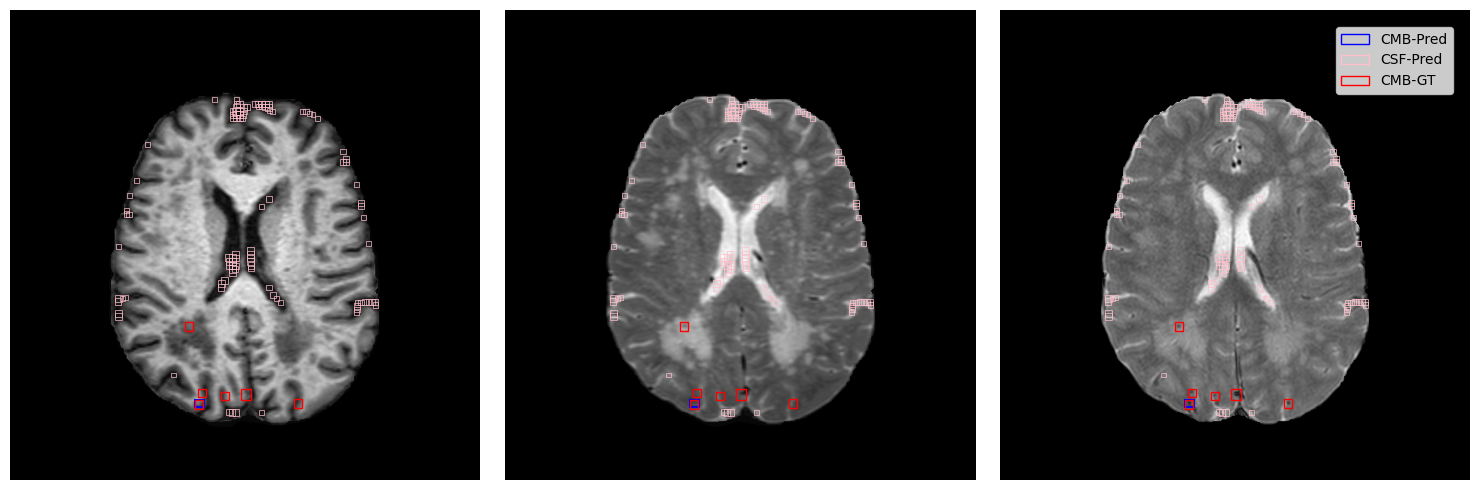

Image: sub-110_slice_021
Ground Truth boxes: 6
Prediction boxes: 100
GT Class distribution: {0: 6}
Prediction Category distribution: {1: 1, 2: 99}


In [36]:
# Your existing YOLO predictions
yolo_output = [
{"image_id": "sub-110_slice_021", "category_id": 1, "bbox": [806.889, 1696.999, 36.258, 34.413], "score": 0.22336}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [539.165, 731.046, 24.032, 24.117], "score": 0.09291}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1549.189, 1260.105, 24.296, 24.31], "score": 0.0912}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1562.81, 1259.661, 26.512, 26.205], "score": 0.09027}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [971.754, 457.274, 26.015, 26.621], "score": 0.08894}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1497.558, 1274.125, 27.558, 27.612], "score": 0.08759}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1081.254, 394.673, 29.331, 29.167], "score": 0.08734}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1452.081, 650.779, 25.53, 25.967], "score": 0.08732}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1096.75, 394.316, 30.082, 29.824], "score": 0.08715}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [505.837, 877.53, 24.152, 24.328], "score": 0.08685}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1066.303, 395.465, 28.308, 28.181], "score": 0.08555}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1498.838, 1291.908, 24.491, 24.894], "score": 0.08543}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [987.401, 457.671, 26.102, 26.439], "score": 0.08464}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1436.21, 650.452, 25.843, 26.364], "score": 0.08436}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1515.297, 842.144, 25.216, 25.67], "score": 0.08378}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [457.864, 1241.804, 28.643, 28.751], "score": 0.08183}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1117.573, 427.173, 22.919, 23.183], "score": 0.08177}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1083.714, 1742.353, 23.161, 22.962], "score": 0.08159}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1534.519, 1260.312, 22.988, 23.276], "score": 0.08155}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [969.082, 440.616, 30.849, 30.833], "score": 0.08139}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1262.984, 429.341, 23.523, 23.328], "score": 0.08122}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1111.612, 409.663, 28.536, 28.482], "score": 0.08114}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [940.248, 1738.646, 26.191, 26.192], "score": 0.0808}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1099.058, 409.177, 27.294, 27.536], "score": 0.08046}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1112.269, 395.038, 28.066, 27.705], "score": 0.08028}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1326.653, 461.623, 22.007, 22.093], "score": 0.07961}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1549.585, 1004.648, 22.352, 22.637], "score": 0.07931}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [954.559, 1739.304, 27.191, 27.564], "score": 0.07908}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1574.829, 1258.925, 27.722, 27.577], "score": 0.07894}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [494.181, 875.806, 24.74, 24.958], "score": 0.07858}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1275.625, 429.319, 24.862, 24.846], "score": 0.07833}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1033.254, 1048.686, 30.04, 30.484], "score": 0.0779}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [458.933, 1320.904, 26.784, 27.804], "score": 0.07784}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [973.936, 380.569, 23.741, 23.684], "score": 0.07765}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1052.281, 396.809, 26.309, 26.421], "score": 0.07764}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1035.042, 1098.097, 27.721, 28.09], "score": 0.07749}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [968.629, 424.626, 30.999, 30.881], "score": 0.07676}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [477.436, 1244.252, 22.189, 22.118], "score": 0.07662}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [984.707, 441.157, 30.055, 29.879], "score": 0.07647}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [959.931, 460.316, 22.442, 23.064], "score": 0.07615}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1499.223, 1305.934, 21.632, 22.961], "score": 0.07586}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1033.606, 1065.203, 29.319, 29.71], "score": 0.07581}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1034.19, 1082.173, 28.368, 28.341], "score": 0.07565}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1000.895, 460.094, 23.495, 24.025], "score": 0.07525}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [970.109, 1739.455, 27.477, 27.46], "score": 0.07481}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [954.398, 1129.965, 28.178, 28.49], "score": 0.07462}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [938.046, 1063.462, 30.874, 31.459], "score": 0.07398}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [968.44, 1113.645, 26.496, 26.76], "score": 0.07393}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1133.026, 1228.953, 24.325, 24.233], "score": 0.07385}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1166.167, 1262.488, 21.473, 21.439], "score": 0.07371}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [958.012, 428.649, 23.686, 23.873], "score": 0.07367}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [938.837, 1080.771, 29.062, 29.477], "score": 0.07353}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [971.155, 409.366, 28.497, 28.709], "score": 0.07333}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [953.656, 1112.01, 31.533, 32.068], "score": 0.07326}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1033.494, 1033.339, 30.299, 30.651], "score": 0.07285}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [456.198, 1256.559, 29.008, 29.223], "score": 0.07279}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1530.395, 892.377, 21.73, 22.32], "score": 0.07278}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [974.038, 394.668, 25.761, 26.21], "score": 0.07266}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1082.656, 842.963, 23.966, 24.487], "score": 0.07192}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [878.993, 379.652, 21.212, 21.104], "score": 0.07171}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1085.719, 408.527, 23.21, 24.266], "score": 0.07165}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [493.652, 1243.227, 20.465, 20.026], "score": 0.07126}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1309.068, 445.557, 20.307, 20.402], "score": 0.07123}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [589.491, 574.068, 20.415, 20.834], "score": 0.0712}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1038.62, 1114.434, 22.779, 23.397], "score": 0.0712}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1115.85, 1195.705, 25.206, 25.233], "score": 0.07114}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [958.902, 443.365, 24.39, 24.683], "score": 0.07105}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [463.026, 1018.885, 20.728, 20.322], "score": 0.07055}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [939.617, 1097.712, 28.752, 28.86], "score": 0.07054}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1517.793, 828.326, 24.173, 24.115], "score": 0.07044}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1501.044, 1263.307, 23.466, 23.638], "score": 0.07012}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1295.179, 441.223, 20.93, 21.29], "score": 0.07}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1516.957, 1261.522, 23.482, 23.733], "score": 0.06986}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1435.945, 603.108, 25.507, 25.408], "score": 0.0698}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1580.943, 1273.937, 22.161, 23.063], "score": 0.06968}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [905.853, 1192.487, 28.152, 29.487], "score": 0.06953}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [952.143, 1063.646, 30.997, 31.8], "score": 0.06949}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [919.508, 1161.824, 29.667, 29.729], "score": 0.06946}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1130.42, 431.535, 22.396, 21.673], "score": 0.06946}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1001.933, 425.14, 28.341, 28.449], "score": 0.06939}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [968.215, 1065.723, 28.073, 28.378], "score": 0.06903}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1000.687, 442.315, 26.344, 26.428], "score": 0.06901}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1115.51, 811.953, 24.611, 24.866], "score": 0.06893}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [510.395, 798.04, 21.254, 21.335], "score": 0.06883}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [984.769, 425.473, 29.932, 29.822], "score": 0.06875}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [952.785, 1080.311, 30.658, 31.138], "score": 0.06861}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [954.358, 1098.854, 29.474, 29.112], "score": 0.06856}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [701.038, 1579.107, 20.816, 20.622], "score": 0.06848}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [986.131, 394.53, 27.335, 27.415], "score": 0.06834}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [968.47, 1048.272, 29.205, 30.066], "score": 0.06829}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1148.446, 1243.765, 21.698, 21.707], "score": 0.06827}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [495.253, 860.272, 23.215, 23.271], "score": 0.06827}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1450.097, 634.529, 26.28, 26.533], "score": 0.06815}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [455.252, 1305.061, 30.119, 30.144], "score": 0.06811}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1069.42, 407.205, 22.701, 23.639], "score": 0.06786}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [967.994, 1099.798, 27.33, 26.536], "score": 0.06768}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1018.888, 408.91, 27.128, 27.626], "score": 0.06762}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [906.552, 1176.112, 30.079, 31.246], "score": 0.06757}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1002.558, 408.566, 29.504, 29.916], "score": 0.06752}, {"image_id": "sub-110_slice_021", "category_id": 2, "bbox": [1496.956, 749.071, 22.59, 22.851], "score": 0.06743},
]

# Your existing parameters
task = "val"
img_num = "110"
slice_num = "021"

# 3 slices
root_path = "/media/Datacenter_storage/Ji/valdo_dataset/valdo_resample_ALFA_YOLO_PNG_epd_gt_box_t2s_GAN_3slices_cmbTrainOnly"


# csf
root_path = "/media/Datacenter_storage/Ji/valdo_dataset/valdo_resample_ALFA_YOLO_PNG_epd_gt_box_GAN_2class_csf"



# all sequence
# root_path = "/media/Datacenter_storage/Ji/valdo_dataset/valdo_all_sequence_cmbOnly_GAN"

visualize_predictions_and_ground_truth(root_path, img_num, slice_num, yolo_output, task)